## Objectives
Using the provided dataset, you are asked to train a model that predicts a book’s rating. The project can be submitted as a Jupyter Notebook (at least) and should include exploratory analysis of the data, feature engineering and selection, model training and evaluation and finally, deployment.
## Invertigation presentation

Analyze which machine learning model is best given our dataset to predict book ratings.

## Dataset source

The dataset provided is a curation of Goodreads books based on real user information. It can be used for many tasks like predicting a book’s rating or recommending new books.
## Dataset attributes

1-bookID: A unique identification number for each book.

2-title: The name under which the book was published.

3-authors: The names of the authors of the book. Multiple authors are delimited by “/”.

4-average_rating: The average rating of the book received in total.

5-isbn: Another unique number to identify the book, known as the International Standard Book Number.

6-isbn13: A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.

7-language_code: Indicates the primary language of the book. For instance, “eng” is standard for English.

8-num_pages: The number of pages the book contains.

9-ratings_count: The total number of ratings the book received.

10-text_reviews_count: The total number of written text reviews the book received.

11-publication_date: The date the book was published.

12-publisher: The name of the book publisher.

# Import dependencies

In [1]:
import pandas as pd
import plotly.express as px
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from fuzzywuzzy import process
import random

import warnings
warnings.filterwarnings('ignore')


C:\Users\tefte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Read the CSV file and store its contents in a DataFrame named 'books_clean'
books_clean = pd.read_csv('books.csv',error_bad_lines=False,warn_bad_lines=False)
books_clean

bookID                                              title  \
0           1  Harry Potter and the Half-Blood Prince (Harry ...   
1           2  Harry Potter and the Order of the Phoenix (Har...   
2           4  Harry Potter and the Chamber of Secrets (Harry...   
3           5  Harry Potter and the Prisoner of Azkaban (Harr...   
4           8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
...       ...                                                ...   
11118   45631   Expelled from Eden: A William T. Vollmann Reader   
11119   45633                        You Bright and Risen Angels   
11120   45634                    The Ice-Shirt (Seven Dreams #1)   
11121   45639                                        Poor People   
11122   45641                        Las aventuras de Tom Sawyer   

                                                 authors  average_rating  \
0                             J.K. Rowling/Mary GrandPré            4.57   
1                             J.K. Rowling/Mary GrandPré            4.49   
2                                           J.K. Rowling            4.42   
3                             J.K. Rowling/Mary GrandPré            4.56   
4                             J.K. Rowling/Mary GrandPré            4.78   
...                                                  ...             ...   
11118  William T. Vollmann/Larry McCaffery/Michael He...            4.06   
11119                                William T. Vollmann            4.08   
11120                                William T. Vollmann            3.96   
11121                                William T. Vollmann            3.72   
11122                                         Mark Twain            3.91   

             isbn         isbn13 language_code    num_pages  ratings_count  \
0      0439785960  9780439785969           eng          652        2095690   
1      0439358078  9780439358071           eng          870        2153167   
2      0439554896  9780439554893           eng          352           6333   
3      043965548X  9780439655484           eng          435        2339585   
4      0439682584  9780439682589           eng         2690          41428   
...           ...            ...           ...          ...            ...   
11118  1560254416  9781560254416           eng          512            156   
11119  0140110879  9780140110876           eng          635            783   
11120  0140131965  9780140131963           eng          415            820   
11121  0060878827  9780060878825           eng          434            769   
11122  8497646983  9788497646987           spa          272            113   

       text_reviews_count publication_date        publisher  
0                   27591        9/16/2006  Scholastic Inc.  
1                   29221         9/1/2004  Scholastic Inc.  
2                     244        11/1/2003       Scholastic  
3                   36325         5/1/2004  Scholastic Inc.  
4                     164        9/13/2004       Scholastic  
...                   ...              ...              ...  
11118                  20       12/21/2004    Da Capo Press  
11119                  56        12/1/1988    Penguin Books  
11120                  95         8/1/1993    Penguin Books  
11121                 139        2/27/2007             Ecco  
11122                  12        5/28/2006    Edimat Libros  

[11123 rows x 12 columns]

# 1- Data cleaning

In [3]:
books_clean.shape

(11123, 12)

<AxesSubplot: >

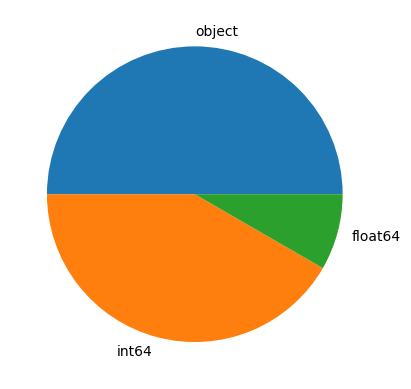

In [4]:
books_clean.dtypes.value_counts().plot.pie()

In [5]:
missing_values = books_clean.isnull().sum()
print(missing_values)

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


We don't have any missing values in the dataframe, which will make our task more easier.

Let's start by invastigating all the variables

# Authors variable

-   We can see that the authors are seperated by '/'. 
-   We are going to see the number of authors for every book.

In [6]:
# we are going to check for the number of others later 
books_clean['numberOfAuthors'] = books_clean['authors'].str.count('/')+1
#we are going to choose the number of authors that are easy to use
books_clean=books_clean.query("numberOfAuthors<=6")
books_clean.describe() 
# we have almost 11000 rows which is rational to use, we are going to lose some information but it's not gonna be useful for the model.
# another reason to split the authors like this so maybe we will need to use some spectral embedding on it
books_clean[['firstAuthor','secondAuthor','thirdAuthor','fourthAuthor','fifthAuthor','sixthAuthor']] = books_clean.authors.str.split("/", expand = True)
#TODO in feature engnering colaboration yes or no variable

# 2- Publication_date variable

In [7]:
books_clean['publication_date_error'] = pd.to_datetime(books_clean['publication_date'], format='%m/%d/%Y', errors='coerce')
# Filter rows where "publication_date" is NaT
filtered_books_clean = books_clean[books_clean['publication_date_error'].isna()]

# here we just want to get the dates that have errors
filtered_books_clean
# afte short invistigation we found that the date 11/31/2000 is out of range because november 2000 has onoly 30 days same as june 1982

bookID                                              title  \
8177    31373  In Pursuit of the Proper Sinner (Inspector Lyn...   
11094   45531         Montaillou  village occitan de 1294 à 1324   

                                               authors  average_rating  \
8177                                 Elizabeth  George            4.10   
11094  Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie            3.96   

             isbn         isbn13 language_code    num_pages  ratings_count  \
8177   0553575104  9780553575101           eng          718          10608   
11094  2070323285  9782070323289           fre          640             15   

       text_reviews_count publication_date       publisher  numberOfAuthors  \
8177                  295       11/31/2000    Bantam Books                1   
11094                   2        6/31/1982  Folio histoire                2   

                   firstAuthor             secondAuthor thirdAuthor  \
8177         Elizabeth  George                     None        None   
11094  Emmanuel Le Roy Ladurie  Emmanuel Le Roy-Ladurie        None   

      fourthAuthor fifthAuthor sixthAuthor publication_date_error  
8177          None        None        None                    NaT  
11094         None        None        None                    NaT

In [8]:
## fixing the two dates
date_mapping = {
    '11/31/2000': '12/01/2001',
    '6/31/1982': '07/01/1982'
}
books_clean['publication_date'] = books_clean['publication_date'].replace(date_mapping)


# Language_code variable

In [9]:
# now lets see the language code column 
unique_language_codes = books_clean['language_code'].unique().tolist()
print(unique_language_codes)
# we notice here that there are some classes that can be grouped

['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm', 'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale']


In [10]:
# Create a dictionary to map values for replacement
language_mapping = {
    'eng-US': 'eng',
    'en-GB': 'eng',
    'en-CA': 'eng',
    'en-US': 'eng'
}

# Replace values in the 'language_code' column using the dictionary
books_clean['language_code'] = books_clean['language_code'].replace(language_mapping)

# Display the updated unique values in the 'language_code' column
unique_language_codes = books_clean['language_code'].unique().tolist()
print(unique_language_codes)

['eng', 'fre', 'spa', 'mul', 'grc', 'enm', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale']


# Publisher variable

In [11]:
unique_publishers = books_clean['publisher'].nunique()
print(f"Number of unique publishers: {unique_publishers}")
# there is a high cardinality here we need to reduce it.


Number of unique publishers: 2278


In [12]:
publisher_counts = books_clean['publisher'].value_counts()
print(publisher_counts.head(20))

Vintage                         317
Penguin Books                   259
Penguin Classics                184
Mariner Books                   149
Ballantine Books                143
HarperCollins                   112
Harper Perennial                112
Bantam                          110
Pocket Books                    109
VIZ Media LLC                    87
Berkley                          86
Dover Publications               84
Modern Library                   82
Del Rey                          79
Grand Central Publishing         76
Oxford University Press  USA     74
Scribner                         73
Tor Books                        72
Oxford University Press          72
Cambridge University Press       66
Name: publisher, dtype: int64


We will reduce the dimmension of publisher in the feature enineering part

In [13]:
# to finish we are just going to do a data type mapping to make sure everythig is okay
data_type_mapping = {
    'bookID': 'category',
    'authors': 'str',
    'average_rating': 'float64',
    'isbn': 'category',
    'isbn13': 'category',
    'language_code': 'category',
    'ratings_count': 'int64',
    'text_reviews_count': 'int64',
    'publisher': 'str',
    'numberOfAuthors': 'int64',
    'firstAuthor': 'category',
    'secondAuthor': 'category',
    'thirdAuthor': 'category',  # Corrected typo here
    'fourthAuthor': 'category',
    'fifthAuthor': 'category',
    'sixthAuthor': 'category'
    
    # Add more columns and data types as needed
}
books_clean = books_clean.astype(data_type_mapping)

Here we finish data cleaning what it left is only feature engniering later.

# 2- Data analysis

We start by exploring the variables of the data numerical and categorical types

# 1- Visualization of numerical data

Remove unnecessary columns

In [14]:
# Removing columns by name
columns_to_remove = ['bookID', 'isbn','isbn13','publication_date']
df= books_clean.drop(columns=columns_to_remove)


In [15]:
# Select only the numeric columns
num_columns = books_clean.select_dtypes(include=['float64', 'int64'])

# Create a grid of subplots with the appropriate number of rows and columns
num_plots = len(num_columns.columns)
rows = 5
cols = 2

# Define the subplot titles
subplot_titles = [f'Histogram of {column}' for column in num_columns.columns]

# Define the heights of the subplot rows (larger = taller subplot)
row_heights = [0.8] * rows

# Create the subplots with customized titles and row heights
fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles, row_heights=row_heights, vertical_spacing=0.1,
    horizontal_spacing=0.05)

# Iterate over each numeric column and add a histogram to the corresponding subplot
for i, column in enumerate(num_columns.columns):
    row = (i // cols) + 1
    col = (i % cols) + 1
    hist_trace = go.Histogram(x=books_clean[column], name=column)
    fig.add_trace(hist_trace, row=row, col=col)

# Adjust the dimensions of the overall figure (width x height)
fig_width = 1000  # Width in pixels
fig_height = 1100  # Height in pixels

# Update the layout and titles
fig.update_layout(
    title='Histograms of Numeric Variables', 
    showlegend=False,
    width=fig_width,  # Adjust the width of the figure
    height=fig_height  # Adjust the height of the figure
)

# Display the final graph
fig.show()

- We can notice our average rating is skewed to the right alitl bit with a mean of 4.
- The num pages is skewed to the left with a mean of almost 380 pages.
- other variables needs more invastigating

Let's start by checking the number of pages variable

In [16]:
# Create a violin plot of the 'number_pages' column using Plotly
fig = px.violin(books_clean, y='  num_pages', box=True, points="all")

# Update the title and axis labels of the plot
fig.update_layout(title='Violin Plot of Number of Pages', yaxis_title='Number of Pages')

# Show the figure
fig.show()

- we can notice that 75% of the data is under 416 pages and almost 25% of the data is between 416 and 752
- we can notice that we have some lines that have more 2000 pages let's invesitagte them more
- for this we need to check if there outliers and clean them see the mean of the number of pages and check where the variability of 95% of the data 

In [17]:
## investigating the number of oages that are more than 1000
# Assuming your dataframe is named books_clean
filtered_books_1000 = books_clean[books_clean['  num_pages'] > 1000]

# Display the updated unique values in the 'language_code' column
unique_title_codes = filtered_books_1000['title'].unique().tolist()
print(unique_title_codes[:5])



['Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5)', 'Harry Potter Collection (Harry Potter  #1-6)', 'J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings', 'The Lord of the Rings (The Lord of the Rings  #1-3)', 'Against the Day']


- We can notice here that there are some title that are a set of books and not one book.
- we will add this as feature enineer step later

Now we will and see the ratings_count variable

In [18]:
# Create a violin plot of the 'ratings_count' column using Plotly
fig = px.violin(books_clean, y='ratings_count', box=True, points="all")

# Update the title and axis labels of the plot
fig.update_layout(title='Violin Plot of ratings count', yaxis_title='ratings count')

# Show the figure
fig.show()



- 75% of the data is under 5053 rating count.
- we need to see maybe with the publisher to see what is the publisher that is most rated.
- we can notice that there are some books with millions of rates we can say that are the most succsful if we compare them to the average rating.

In [19]:
# Create a violin plot of the 'text_reviews_count' column using Plotly
fig = px.violin(books_clean, y='text_reviews_count', box=True, points="all")

# Update the title and axis labels of the plot
fig.update_layout(title='Violin Plot of text_reviews_count', yaxis_title='text_reviews_count')

# Show the figure
fig.show()

- the text reviews count is gonna behave the same as rating count since they are related.
- if someone rated the book there is high chance it's going to comment.
- we will use only one variable later in the model

Now let's see the average rating variable.

In [20]:
# Create a violin plot of the 'average_rating	' column using Plotly
fig = px.violin(books_clean, y='average_rating', box=True, points="all")

# Update the title and axis labels of the plot
fig.update_layout(title='Violin Plot of average_rating', yaxis_title='average_rating')

# Show the figure
fig.show()

we can notice here that 50% of the dooks have from 3.78 to 4.14 reveiws 25% is from 4.13 to 5 and 25% of the books are from 0to 3.78 
which means that our target varialbe is well distrubted

# Visualizing Qualitative Data

We will start with the langauge code variable

In [21]:
import plotly.graph_objects as go

col = 'language_code'
value_counts = books_clean[col].value_counts()
top_languages = value_counts.head(5)

# Create a pie chart using Plotly
fig = go.Figure(data=[go.Pie(labels=top_languages.index,
                             values=top_languages.values,
                             hole=.3,  # This creates a "donut" appearance. Remove if you want a full pie.
                             textinfo='percent+label')])

fig.update_layout(title_text=f"Distribution of Top 5 Languages ({col})")

# Show the plot
fig.show()


The dataset is predominantly composed of the English language.

In [22]:
import plotly.graph_objects as go

col = 'authors'
value_counts = books_clean[col].value_counts()
top_authors = value_counts.head(20)

# Create a pie chart using Plotly
fig = go.Figure(data=[go.Pie(labels=top_authors.index,
                             values=top_authors.values,
                             hole=.3,  # This creates a "donut" appearance. Remove if you want a full pie.
                             textinfo='percent+label')])

fig.update_layout(title_text=f"Distribution of Top 20 Authors ({col})")

# Show the plot
fig.show()

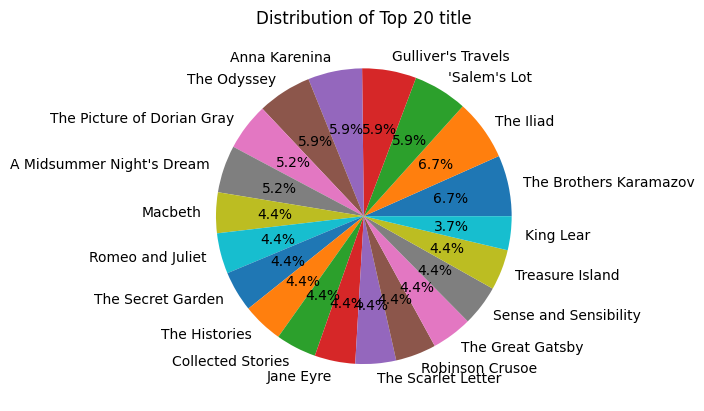

In [23]:
# Specify the name of the column for which you want to create the pie chart
col = 'title'

# Calculate value counts for each unique value in the specified column
value_counts = books_clean[col].value_counts()

# Select only the top 5 languages
top_languages = value_counts.head(20)

# Create a new figure for the pie chart
plt.figure()

# Plot the pie chart with percentage labels using autopct='%.1f%%'
ax = top_languages.plot.pie(autopct='%.1f%%')

# Set the aspect ratio to make the graph a circle rather than an ellipse
ax.set_aspect("equal")

# Set the title of the pie chart using the name of the specified column
plt.title(f"Distribution of Top 20 {col}")

# Remove the default label for the y-axis
plt.ylabel("")

# Display the pie chart
plt.show()

Now let's see the publisher variable

In [24]:
publisher_count = books_clean['publisher'].value_counts().reset_index()
publisher_count.columns = ['publisher', 'Count']

print(publisher_count)

                        publisher  Count
0                         Vintage    317
1                   Penguin Books    259
2                Penguin Classics    184
3                   Mariner Books    149
4                Ballantine Books    143
...                           ...    ...
2273  University Press of America      1
2274              Abstract Studio      1
2275  Jones & Bartlett Publishers      1
2276          Pinter & Martin Ltd      1
2277                    VeloPress      1

[2278 rows x 2 columns]


In [25]:
publisher_count = books_clean['publisher'].value_counts().reset_index()
publisher_count.columns = ['publisher', 'Count']
sorted_counts = publisher_count['Count'].sort_values().reset_index(drop=True)
fig = go.Figure(data=go.Histogram(x=publisher_count['Count'], histnorm='probability density', marker=dict(color='blue', line=dict(width=0.5, color='black'))))
fig.update_layout(title='Distribution of Counts (Log Scale)', xaxis_title='Count', yaxis_title='Number of Publishers', yaxis_type='log')
fig.show()



- the most valuable insight that we can take from this plot is that most of the publisher have 50 publication of less with almost 30% of the data have only one publication 
- this leads to think about reducing this dimension later in feature engineering

# Visualization of numerical data/Target

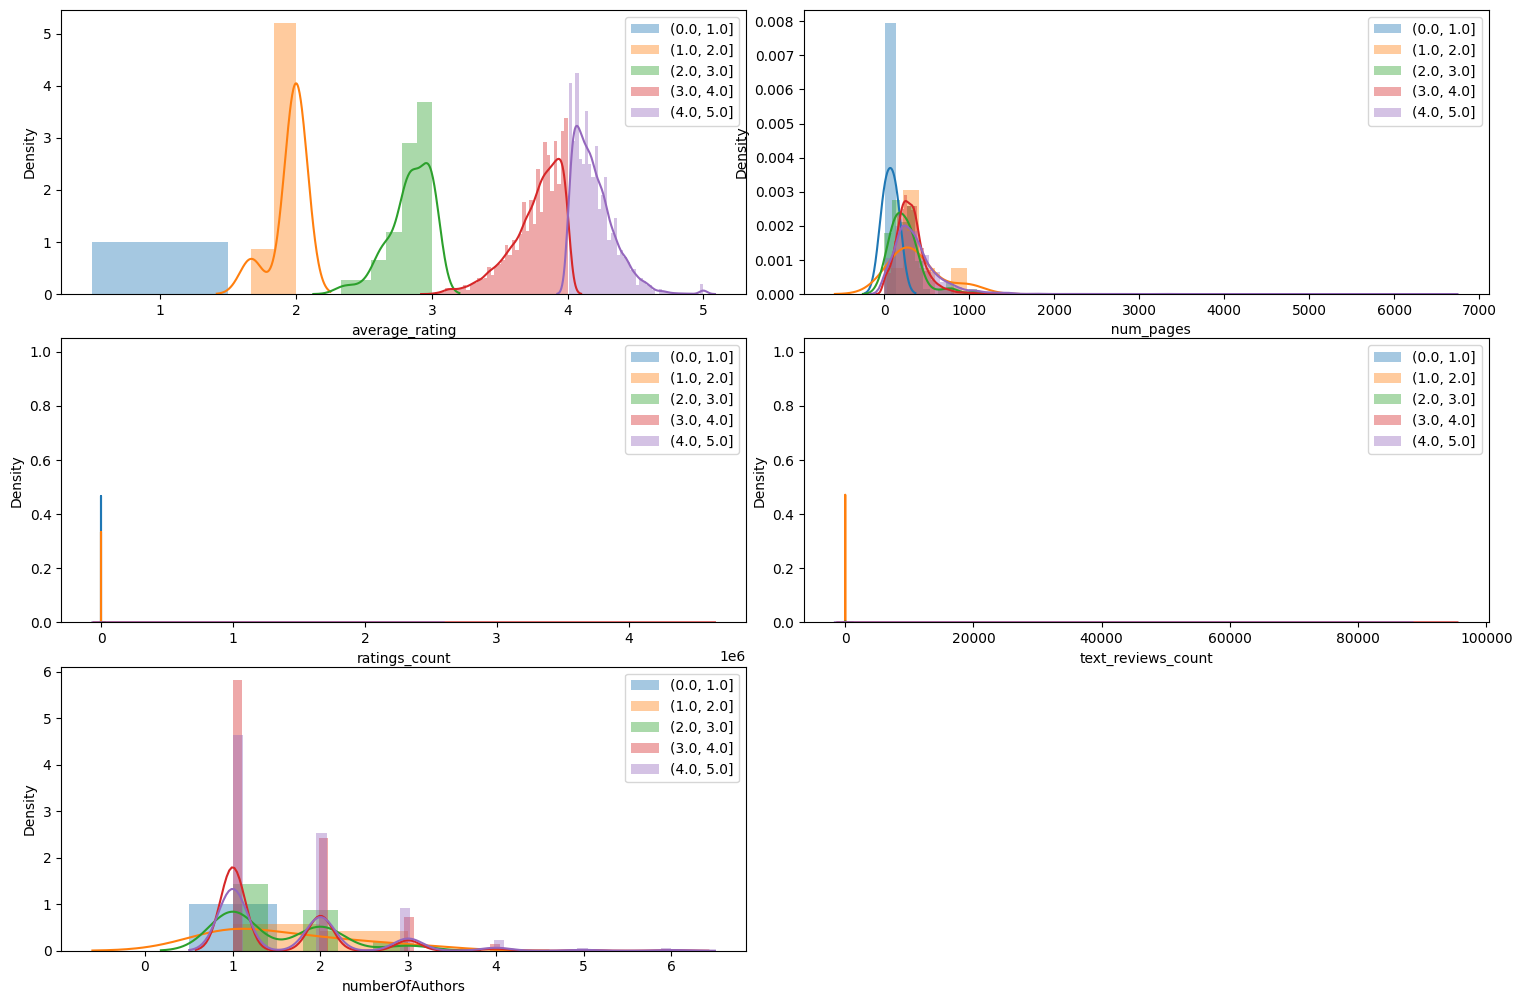

In [26]:
# Define the boundaries of the intervals
bins = np.arange(0, 6, 1)
# Add the "bins" column based on the "ratings" column
books_clean['interval'] = pd.cut(books_clean['average_rating'], bins=bins)
books_clean['interval'] = books_clean['interval'].astype(str)

avis_very_poor = books_clean[books_clean['interval'] == '(0, 1]']
avis_poor = books_clean[books_clean['interval'] == '(1, 2]']
avis_fair_poor = books_clean[books_clean['interval'] == '(2, 3]']
avis_fair_good = books_clean[books_clean['interval'] == '(3, 4]']
avis_excellent = books_clean[books_clean['interval'] == '(4, 5]']
# Liste des colonnes de type float dans le DataFrame df
float_columns = books_clean.select_dtypes(['float64', 'int64']).columns

# Calcul du nombre de sous-graphiques nécessaires en fonction du nombre de colonnes
num_subplots = len(float_columns)
num_cols = 2  # Define the number of columns you want in each row

# Calcul du nombre de lignes en fonction du nombre de sous-graphiques et de colonnes
num_rows = (num_subplots + num_cols - 1) // num_cols

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

fig.tight_layout()

# Boucle à travers les colonnes et les sous-graphiques
for i, col in enumerate(float_columns):
    row_idx = i // num_cols  # Ligne actuelle
    col_idx = i % num_cols   # Colonne actuelle
    
    ax = axes[row_idx, col_idx]  # Sélectionne le sous-graphique actuel
    
    # Utilisation d'un contexte pour ignorer les avertissements spécifiques
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.distplot(avis_very_poor[col], label='(0.0, 1.0]', ax=ax)
        sns.distplot(avis_poor[col], label='(1.0, 2.0]', ax=ax)
        sns.distplot(avis_fair_poor[col], label='(2.0, 3.0]', ax=ax)
        sns.distplot(avis_fair_good[col], label='(3.0, 4.0]', ax=ax)
        sns.distplot(avis_excellent[col], label='(4.0, 5.0]', ax=ax)
        ax.legend()
    

# Supprime les sous-graphiques inutilisés s'il y en a
if num_subplots < (num_rows * num_cols):
    for i in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Affiche le tracé
plt.show()


# num_pages
Based on the plot above, it is evident that the page number has an influence on the average rating
as there is a shift between the Gaussian curves of each review type.
# ratings_count
According to the ratings counts plot, a notable observation is that reviews with a "Poor" rating exhibit significantly lower or nearly negligible rating counts when compared to those with "Excellent" ratings. 
# day:
The first day of the month exhibits a prominent peak in the Gaussian-like curve in contrast to the other days of the month. This could be hypothesized as follows: People might be inclined to make more purchases or engage more with a product or service at the beginning of the month due to the receipt of their salaries.
# month:
The pronounced peak observed in the ninth month holds a compelling explanation grounded in two key factors. First, it aligns with the strategic timing that authors and publishers often adopt, releasing their books in sync with the onset of the autumn season. This strategic decision is especially prominent as the year-end holidays draw near, capitalizing on increased readership during the festive period. Second, this temporal alignment results in an observable surge in positive reviews, likely influenced by the heightened availability and consumption of new literary works. By conducting temporal analysis and evaluating the sentiment dynamics within this time frame, it becomes evident that this phenomenon can be attributed to the interplay of seasonal book releases and the subsequent reader engagement patterns.

Now let's move to the num of pages VS average rating

In [27]:
import plotly.express as px

fig = px.scatter(books_clean, x="  num_pages", y="average_rating",
                 title="Relationship between Number of Pages and Average Rating")

fig.show()

- first of all we can't say that when ever the num pages is inceasing the average_rating is increasing.
- we can notice that is centred in between 0-1000 number of pages which we need to invastigat more that part which means add another variable to the plot 

In [28]:
import plotly.express as px

# Filter your data to only include books with 0-1000 pages
subset_data = books_clean[books_clean['  num_pages'] <= 1000]

fig = px.density_heatmap(subset_data, x='  num_pages', y="average_rating",
                         nbinsx=50, nbinsy=50, 
                         color_continuous_scale=px.colors.sequential.Viridis,
                         title="Hexbin Plot of Number of Pages vs. Average Rating",
                         marginal_x="histogram", marginal_y="histogram")

fig.show()

- this heatmap shows intresting informations we can see that the region where there is from green to yellow is the most region where num pages is contributing the most on the average rating.
- the most yellow part is having the number of pages from 240 to 259 with almost average rating of 4.

Now let's see the language code variable.

In [29]:
# Aggregate data based on language_code
agg_data = books_clean.groupby('language_code').agg(
    median_rating=('average_rating', 'median'),
    count=('language_code', 'size')
).reset_index()

# Plotting
fig = go.Figure()

fig.add_trace(
    go.Bar(x=agg_data['language_code'], 
           y=agg_data['median_rating'], 
           text=agg_data['count'],
           marker=dict(color=agg_data['median_rating'], colorscale='Viridis'))
)

fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.update_layout(title='Median Rating by Language with Number of Books Indicated',
                  xaxis_title='Language',
                  yaxis_title='Median Rating')

fig.show()

- we can notice here that we can reduce the dimensionality of the language code by what by the number of books that we have in that language which means we can try to merge some languages together
we will add this too the the feature engineering

we can't say that when ever the num pages is inceasing the average_rating is increasing, we can notice that is centred in between 0-1000 number of pages which we need to
invastigat more that part which means add another variable to the plot.

Now let's go for the text reviews count VS Average Rating.

In [30]:
import plotly.express as px

fig = px.scatter(books_clean, x="text_reviews_count", y="average_rating", 
                 title="Scatter Plot of Text Reviews Count vs. Average Rating",
                 marginal_y="histogram", marginal_x="histogram")

fig.show()


In [31]:
import numpy as np

# Create the 'log_text_reviews_count' column
books_clean['log_text_reviews_count'] = np.log1p(books_clean['text_reviews_count']) # using log1p to ensure log(0) does not result in negative infinity

import plotly.graph_objects as go

# Create 2D histogram
fig = go.Figure(go.Histogram2d(
        x=books_clean["log_text_reviews_count"],
        y=books_clean["average_rating"],
        colorscale="Blues",  # Change the colorscale as you like
        zmax=1,
        nbinsx=50,  # You can adjust the number of bins
        nbinsy=50,
    ))

# Update the layout
fig.update_layout(
    title="2D Histogram of Log(Text Reviews Count) vs. Average Rating",
    xaxis_title="Log(Text Reviews Count)",
    yaxis_title="Average Rating",
    annotations=[
        dict(
            showarrow=False,
            x=1.05,
            y=1.05,
            xref='paper',
            yref='paper',
            text="Count",
            font=dict(size=14)
        )
    ]
)

fig.show()


- we can notice here thath the most region that is contorbuting for the average rating  the most blue one with the log text reveiws count 3.75 and the average rating of 4.09

# PRE-PROCESSING AND FEATURE ENGINEERING

First we create a new variable of publication date.

In [32]:
# Convert 'publication_date' to datetime dtype
books_clean['publication_date'] = pd.to_datetime(books_clean['publication_date'])

# Extract day, month, and year
books_clean['day'] = books_clean['publication_date'].dt.day
books_clean['month'] = books_clean['publication_date'].dt.month
books_clean['year'] = books_clean['publication_date'].dt.year


Next we are going to create a variable saying if it's set of books or one book

In [33]:
## let's fix the title without removing the num of pages that are as outliers
def check_book_type(title):
    # Some patterns and keywords that are often present in titles of multiple books
    keywords = ['set', 'collection', 'boxed', 'volume', 'volumes', 'trilogy', '#1-', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', 'volume i', 'volume ii', '1-', '2-', '3-', '4-', '5-', '6-', '7-', '8-', 'series', '/']
    for keyword in keywords:
        if keyword in title.lower():
            return '1'
    return '0'
books_clean['bookType'] = books_clean['title'].apply(check_book_type)



- Now let's create new variable to reduce the dimension of language code 
- We are going to put the languages that have less then 15 books as others langugages.

In [34]:
# Count the number of observations per language_code
language_counts = books_clean['language_code'].value_counts()

 

# Create a new column lang_code_new
# If the observation count is less than 2, assign 'others'
# Otherwise, keep the value of language_code
books_clean['lang_code_new'] = books_clean['language_code'].apply(lambda x: 'others' if language_counts[x] < 15 else x)


here we are going to replace the num of pages that are 0 with the mediane because it's not correct to use 0 as number of pages

In [35]:
# Calculate the median of the 'num_pages' column, excluding zeros
median_value = books_clean[books_clean['  num_pages'] != 0]['  num_pages'].median()

# Replace zeros with the calculated median value
books_clean['  num_pages'] = books_clean['  num_pages'].replace(0, median_value)

Add the "genre" column to the DataFrame.
- We are adding here the type variable because we know that it's important to use such a variable and it's going to help in our model performance

In [36]:
json_data_list = []

# Open the Gzip file in binary mode for reading
with gzip.open('goodreads_book_genres_initial.json.gz', 'rb') as json_file:
    for line in json_file:
        # Decode each line and load the JSON
        json_data = json.loads(line.decode('utf-8'))
        json_data_list.append(json_data)

# Convert the list of JSON objects into a DataFrame
json_df = pd.DataFrame(json_data_list)

In [37]:

books_clean.rename(columns={'bookID': 'book_id'}, inplace=True)
json_df['book_id'] = json_df['book_id'].astype(int)
books_clean_merged = pd.merge(books_clean, json_df, on="book_id", how="left")
def get_max_key(d):
    if isinstance(d, dict): 
        if d:  
            return max(d, key=d.get)
    return None  

books_clean_merged['type'] = books_clean_merged['genres'].apply(get_max_key)
books_clean_merged['type'].fillna('others', inplace=True)


In [38]:
books_clean_merged['collaboration'] = books_clean_merged['numberOfAuthors'].apply(lambda x: 'Yes' if x > 1 else 'No')
#here we are going to create a new variable that is collaboration that says if we have collaboration between authoers or no so we can make it easy to create a model

now let's break donw the publisher variable to classes (Rare publishers, medium publishers and famous publishers )

In [39]:
books_clean_merged


book_id                                              title  \
0            1  Harry Potter and the Half-Blood Prince (Harry ...   
1            2  Harry Potter and the Order of the Phoenix (Har...   
2            4  Harry Potter and the Chamber of Secrets (Harry...   
3            5  Harry Potter and the Prisoner of Azkaban (Harr...   
4            8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
...        ...                                                ...   
10980    45631   Expelled from Eden: A William T. Vollmann Reader   
10981    45633                        You Bright and Risen Angels   
10982    45634                    The Ice-Shirt (Seven Dreams #1)   
10983    45639                                        Poor People   
10984    45641                        Las aventuras de Tom Sawyer   

                                                 authors  average_rating  \
0                             J.K. Rowling/Mary GrandPré            4.57   
1                             J.K. Rowling/Mary GrandPré            4.49   
2                                           J.K. Rowling            4.42   
3                             J.K. Rowling/Mary GrandPré            4.56   
4                             J.K. Rowling/Mary GrandPré            4.78   
...                                                  ...             ...   
10980  William T. Vollmann/Larry McCaffery/Michael He...            4.06   
10981                                William T. Vollmann            4.08   
10982                                William T. Vollmann            3.96   
10983                                William T. Vollmann            3.72   
10984                                         Mark Twain            3.91   

             isbn         isbn13 language_code    num_pages  ratings_count  \
0      0439785960  9780439785969           eng          652        2095690   
1      0439358078  9780439358071           eng          870        2153167   
2      0439554896  9780439554893           eng          352           6333   
3      043965548X  9780439655484           eng          435        2339585   
4      0439682584  9780439682589           eng         2690          41428   
...           ...            ...           ...          ...            ...   
10980  1560254416  9781560254416           eng          512            156   
10981  0140110879  9780140110876           eng          635            783   
10982  0140131965  9780140131963           eng          415            820   
10983  0060878827  9780060878825           eng          434            769   
10984  8497646983  9788497646987           spa          272            113   

       text_reviews_count  ... interval log_text_reviews_count  day month  \
0                   27591  ...   (4, 5]              10.225281   16     9   
1                   29221  ...   (4, 5]              10.282677    1     9   
2                     244  ...   (4, 5]               5.501258    1    11   
3                   36325  ...   (4, 5]              10.500289    1     5   
4                     164  ...   (4, 5]               5.105945   13     9   
...                   ...  ...      ...                    ...  ...   ...   
10980                  20  ...   (4, 5]               3.044522   21    12   
10981                  56  ...   (4, 5]               4.043051    1    12   
10982                  95  ...   (3, 4]               4.564348    1     8   
10983                 139  ...   (3, 4]               4.941642   27     2   
10984                  12  ...   (3, 4]               2.564949   28     5   

       year bookType lang_code_new  \
0      2006        0           eng   
1      2004        0           eng   
2      2003        0           eng   
3      2004        0           eng   
4      2004        1           eng   
...     ...      ...           ...   
10980  2004        0           eng   
10981  1988        0           eng   
10982  1993        0           eng   
10983  2007        0   

In [40]:
# Calculate the number of books per publisher
publisher_counts = books_clean_merged['publisher'].value_counts()

# function to classify publishers based on counts
def classify_publisher(count):
    if count < 15:
        return 'Rare'
    elif count <= 100:
        return 'Medium'
    else:
        return 'Famous'

# Map the counts to publisher names, and then classify using the function
books_clean_merged['publisher_class'] = books_clean_merged['publisher'].map(publisher_counts).apply(classify_publisher)


We are going to use the correlation metrix to help us more in the feature selection

<AxesSubplot: >

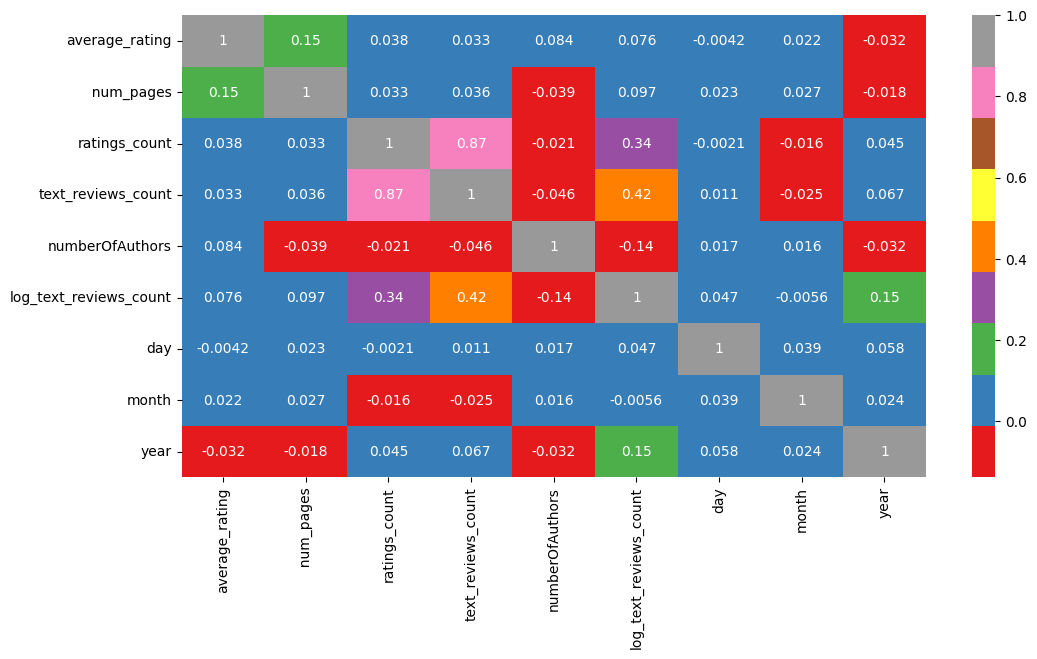

In [41]:
## this  we need it for later
cor = books_clean.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True)

Now we will keep only the features that we will use in the training set

In [42]:
print(books_clean_merged.columns)

Index(['book_id', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'numberOfAuthors', 'firstAuthor',
       'secondAuthor', 'thirdAuthor', 'fourthAuthor', 'fifthAuthor',
       'sixthAuthor', 'publication_date_error', 'interval',
       'log_text_reviews_count', 'day', 'month', 'year', 'bookType',
       'lang_code_new', 'genres', 'type', 'collaboration', 'publisher_class'],
      dtype='object')


- from all the data analysis we did we can feature select all these variables
- we are going to remove all this variables and leave the others: 'book_id', 'title', 'authors','isbn', 'isbn13','language_code','publication_date','numberOfAuthors', 'firstAuthor','secondAuthor', 'thirdAuthor', 'fourthAuthor', 'fifthAuthor','sixthAuthor', 'publication_date_error', 'interval','log_text_reviews_count','genres' 
- why we remove all of this because some of them are ID's and the others we created variables for them to more explain average rating (our target) more easily, and also to reduce the high cardinality like from authors, langauge code, and publisher (we are going to keep publisher)

In [43]:
columns_to_remove = ['publisher','book_id', 'title', 'authors','isbn', 'isbn13','language_code','publication_date','numberOfAuthors', 'firstAuthor','secondAuthor', 'thirdAuthor', 'fourthAuthor', 'fifthAuthor','sixthAuthor', 'publication_date_error', 'interval','log_text_reviews_count','genres']

train= books_clean_merged.drop(columns=columns_to_remove)

In [44]:
train = train.rename(columns={'  num_pages': 'num_pages'})
print(train.columns)

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'day', 'month', 'year', 'bookType', 'lang_code_new', 'type',
       'collaboration', 'publisher_class'],
      dtype='object')


In [46]:
train.to_csv('train.csv', index=False)

This is the end of the journey THANK YOU for your attention!